<a href="https://colab.research.google.com/github/Piyumi22/UCSD-Microgrid-Database/blob/master/Wind_EDA1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## 0.Importing the Libraries

In [2]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
import random

import matplotlib.pyplot as plt
import os

import seaborn as sns
import plotly.graph_objects as go
import plotly.express as px
from plotly.subplots import make_subplots
import plotly.offline as pyo

import os
import datetime

import IPython
import IPython.display

import tensorflow as tf


In [3]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


# wind data download

https://meteostat.net/en/station/72290?t=2018-12-04/2018-12-04

In [4]:
#! pip install meteostat pandas

In [5]:
'''
from datetime import datetime
from meteostat import Hourly
import pandas as pd

# Define the time period
start = datetime(2015, 1, 21)
end = datetime(2020, 2, 29, 23, 59)

# Replace '72290' with the desired station ID
station_id = '72290'

# Fetch hourly weather data for the specified station and time period
data = Hourly(station_id, start, end)
data = data.fetch()

# Convert the data to a pandas DataFrame
df = data.copy()  # Create a copy of the data
df.reset_index(inplace=True)  # Reset the index to have datetime as a column

# Save the sorted DataFrame to a new CSV file
file_path = '/content/drive/MyDrive/FYRP/ME420-RESEARCH/UCSD Microgrid Database/Data Files/weather_data.csv'
df.to_csv(file_path)

print(f"Data saved to weather_data.csv")
'''


'\nfrom datetime import datetime\nfrom meteostat import Hourly\nimport pandas as pd\n\n# Define the time period\nstart = datetime(2015, 1, 21)\nend = datetime(2020, 2, 29, 23, 59)\n\n# Replace \'72290\' with the desired station ID\nstation_id = \'72290\'\n\n# Fetch hourly weather data for the specified station and time period\ndata = Hourly(station_id, start, end)\ndata = data.fetch()\n\n# Convert the data to a pandas DataFrame\ndf = data.copy()  # Create a copy of the data\ndf.reset_index(inplace=True)  # Reset the index to have datetime as a column\n\n# Save the sorted DataFrame to a new CSV file\nfile_path = \'/content/drive/MyDrive/FYRP/ME420-RESEARCH/UCSD Microgrid Database/Data Files/weather_data.csv\'\ndf.to_csv(file_path)\n\nprint(f"Data saved to weather_data.csv")\n'

#1.EDA on Wind data

In [315]:
# Load the CSV file into a DataFrame
file_path = '/content/drive/MyDrive/FYRP/ME420-RESEARCH/UCSD Microgrid Database/Data Files/weather_data.csv'
data = pd.read_csv(file_path)


##1.0 pandas profiling


In [ ]:
from pandas_profiling import ProfileReport

profile = ProfileReport(data)# Create a Pandas Profiling report
profile.to_notebook_iframe()# Display the report (can also be saved to an HTML file)

In [ ]:
!pip install pandas-profiling

##1.1data preprocessing

In [316]:
data.describe()

,Unnamed: 0,temp,dwpt,rhum,prcp,snow,wdir,wspd,wpgt,pres,tsun,coco
count,44784.000000,44783.000000,44780.000000,44780.000000,43250.000000,0.0,40288.000000,44782.000000,0.0,44320.000000,0.0,15543.000000
mean,22391.500000,18.506866,11.488899,66.537204,0.025794,NaN,236.851594,8.926316,NaN,1015.731209,NaN,3.139484
std,12928.171564,4.108475,5.695723,17.210477,0.343637,NaN,94.976269,6.566615,NaN,3.568052,NaN,1.754997
min,0.000000,3.900000,-20.700000,4.000000,0.000000,NaN,0.000000,0.000000,NaN,999.300000,NaN,0.000000
25%,11195.750000,15.600000,8.900000,59.000000,0.000000,NaN,190.000000,5.400000,NaN,1013.200000,NaN,2.000000
50%,22391.500000,18.300000,12.300000,70.000000,0.000000,NaN,275.500000,9.400000,NaN,1015.400000,NaN,3.000000
75%,33587.250000,21.100000,15.600000,78.000000,0.000000,NaN,310.000000,13.000000,NaN,1018.000000,NaN,4.000000
max,44783.000000,37.800000,22.900000,100.000000,30.000000,NaN,360.000000,59.400000,NaN,1032.500000,NaN,25.000000


In [317]:
print(data.isna().sum()) #check nan values

Unnamed: 0        0
time              0
temp              1
dwpt              4
rhum              4
prcp           1534
snow          44784
wdir           4496
wspd              2
wpgt          44784
pres            464
tsun          44784
coco          29241
dtype: int64


### Feature engineering
-remove some specific features; 'snow', 'wpgt', 'tsun', 'coco' has no value or just one year data.
'prcp' has many missing values and has less correlation between any of features.



In [318]:
import pandas as pd

features_to_remove = [ 'snow', 'wpgt', 'tsun', 'coco','prcp']#  list of features to remove

# Double-check that features exist in the DataFrame
for feature in features_to_remove:
    if feature not in data.columns:
        print(f"Warning: Feature '{feature}' not found in DataFrame.")

df = data.drop(features_to_remove, axis=1)# Drop the specified features

**sort and remove duplicates**

In [319]:
df['DateTime'] = pd.to_datetime(df['time'], format='%Y-%m-%d %H:%M:%S')  # Convert 'time' column to datetime format.
df = df.drop_duplicates(subset='DateTime')  # Drop duplicates of DateTime.
df.set_index('DateTime', inplace=True)  # Set 'DateTime' as the index.
df = df.sort_index()  # Sort data according to index.

In [320]:
df.pop ('Unnamed: 0')
df.pop ('time')

DateTime
2015-01-21 00:00:00    2015-01-21 00:00:00
2015-01-21 01:00:00    2015-01-21 01:00:00
2015-01-21 02:00:00    2015-01-21 02:00:00
2015-01-21 03:00:00    2015-01-21 03:00:00
2015-01-21 04:00:00    2015-01-21 04:00:00
                              ...         
2020-02-29 19:00:00    2020-02-29 19:00:00
2020-02-29 20:00:00    2020-02-29 20:00:00
2020-02-29 21:00:00    2020-02-29 21:00:00
2020-02-29 22:00:00    2020-02-29 22:00:00
2020-02-29 23:00:00    2020-02-29 23:00:00
Name: time, Length: 44784, dtype: object

In [321]:
df.head()

,temp,dwpt,rhum,wdir,wspd,pres
DateTime,,,,,,
2015-01-21 00:00:00,16.1,10.6,70.0,220.0,7.6,1014.3
2015-01-21 01:00:00,15.6,10.6,72.0,270.0,13.0,1014.3
2015-01-21 02:00:00,15.0,10.6,75.0,270.0,9.4,1014.4
2015-01-21 03:00:00,15.0,10.6,75.0,230.0,7.6,1014.8
2015-01-21 04:00:00,15.0,10.6,75.0,NaN,0.0,1015.0


**fill missing values**

In [322]:
#fill features with last non nan value or prev non nan value
df.fillna(method='ffill', inplace=True)
# Alternatively, use the fillna method with pad (which is equivalent to forward-fill)
df.fillna(method='pad', inplace=True)


In [323]:
print(df.isna().sum())

temp    0
dwpt    0
rhum    0
wdir    0
wspd    0
pres    0
dtype: int64


###**Wind**


wdir (deg)—gives the wind direction in units of degrees. Angles do not make good model inputs: 360° and 0° should be close to each other and wrap around smoothly. Direction shouldn't matter if the wind is not blowing.

the distribution of wind data;

In [324]:
df['wspd'].max()

59.4

Text(0, 0.5, 'Wind speed [m/s]')

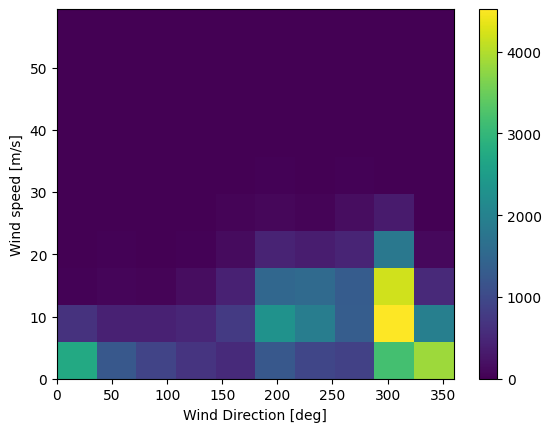

In [325]:
plt.hist2d(df['wdir'], df['wspd'] )
plt.colorbar()
plt.xlabel('Wind Direction [deg]')
plt.ylabel('Wind speed [m/s]')

convert the wind direction and velocity columns to a wind vector:

In [326]:
wspd = df['wspd']

# Convert to radians.
wd_rad = df.pop('wdir')*np.pi / 180 #pop remove values from df

# Calculate the wind x and y components.
df['Wx'] = wspd*np.cos(wd_rad)
df['Wy'] = wspd*np.sin(wd_rad)

The distribution of wind vectors

(-51.44190898479566, 30.57069675359067, -51.013041606032374, 34.16558216310642)

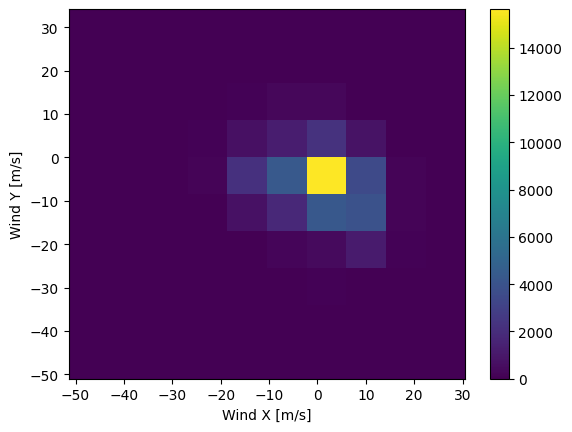

In [327]:
plt.hist2d(df['Wx'], df['Wy'])
plt.colorbar()
plt.xlabel('Wind X [m/s]')
plt.ylabel('Wind Y [m/s]')
ax = plt.gca()
ax.axis('tight')

###**Time**

Similarly, the Date Time column is very useful, but not in this string form. Start by converting it to seconds:

In [328]:
timestamp_s = df.index.map(pd.Timestamp.timestamp)

In [ ]:
timestamp_s

the time in seconds is not a useful model input. Being weather data, it has clear daily and yearly periodicity.

get usable signals by using sine and cosine transforms to clear "Time of day" and "Time of year" signals:

In [329]:
day = 24*60*60
year = (365.2425)*day

df['Day sin'] = np.sin(timestamp_s * (2 * np.pi / day))
df['Day cos'] = np.cos(timestamp_s * (2 * np.pi / day))
df['Year sin'] = np.sin(timestamp_s * (2 * np.pi / year))
df['Year cos'] = np.cos(timestamp_s * (2 * np.pi / year))

Text(0.5, 1.0, 'Time of day signal')

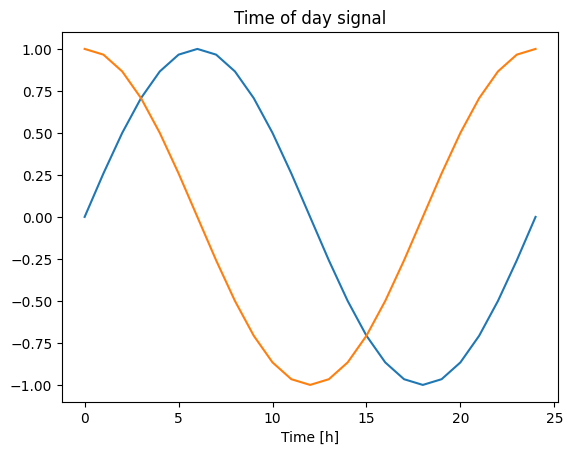

In [330]:
plt.plot(np.array(df['Day sin'])[:25])
plt.plot(np.array(df['Day cos'])[:25])
plt.xlabel('Time [h]')
plt.title('Time of day signal')

Text(0.5, 1.0, 'Time of Year signal')

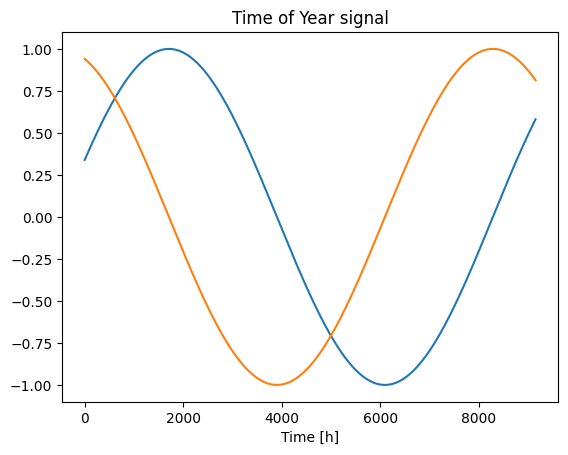

In [331]:
plt.plot(np.array(df['Year sin'])[:25*366])
plt.plot(np.array(df['Year cos'])[:25*366])
plt.xlabel('Time [h]')
plt.title('Time of Year signal')

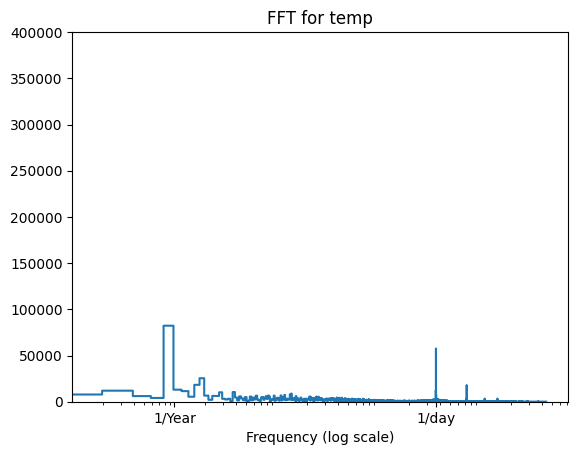

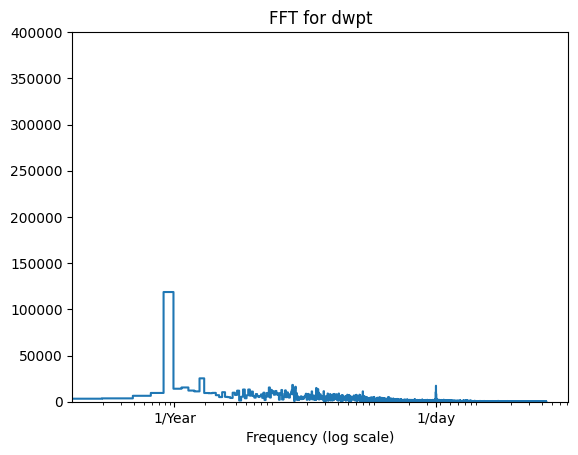

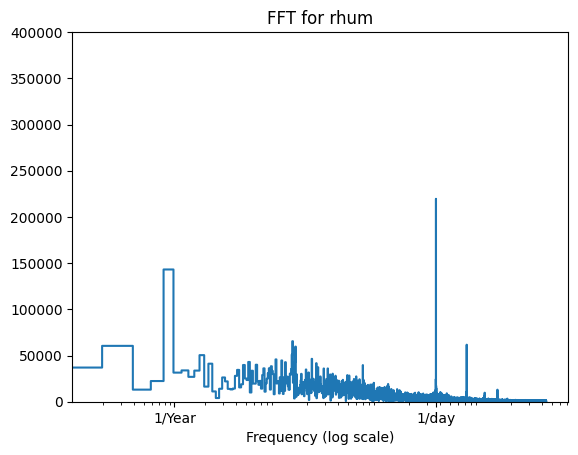

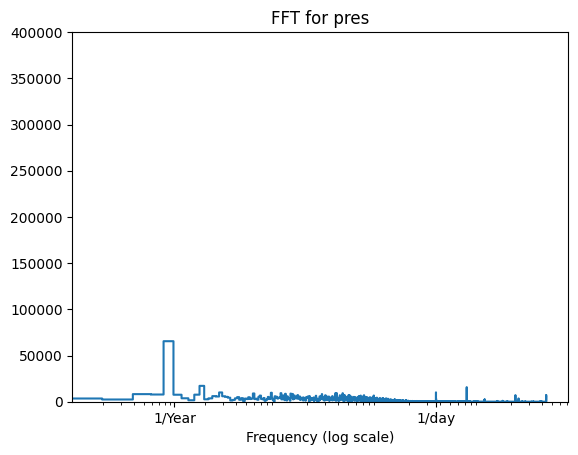

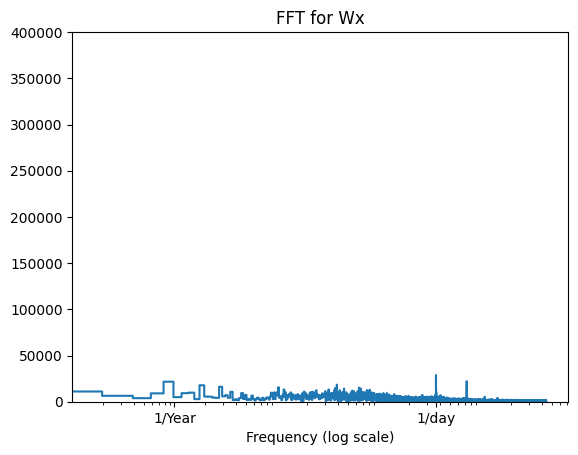

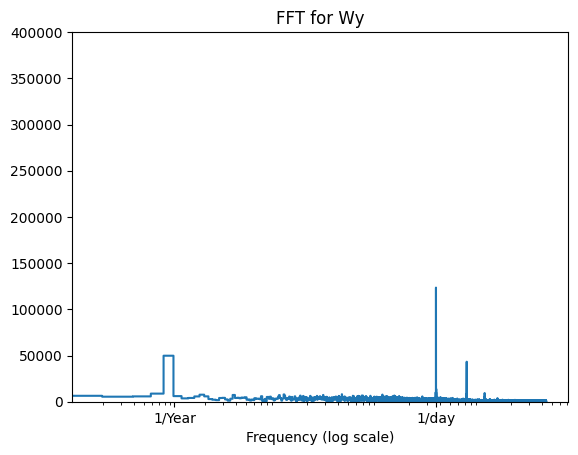

In [332]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt

features= ['temp', 'dwpt', 'rhum', 'pres', 'Wx','Wy']

for feature in features:
    # Extract the column from the DataFrame
    column = df[feature].values

    # Compute the FFT
    fft = tf.signal.rfft(column)

    # Set up the frequency axis
    f_per_dataset = np.arange(0, len(fft))
    n_samples = len(column)
    hours_per_year = 24 * 365.2524
    years_per_dataset = n_samples / hours_per_year
    f_per_year = f_per_dataset / years_per_dataset

    # Plot the FFT
    plt.figure()
    plt.step(f_per_year, np.abs(fft))
    plt.xscale('log')
    plt.ylim(0, 400000)
    plt.xlim([0.1, max(plt.xlim())])
    plt.xticks([1, 365.2524], labels=['1/Year', '1/day'])
    plt.xlabel('Frequency (log scale)')
    plt.title(f'FFT for {feature}')
    plt.show()

In [333]:
df.head()

,temp,dwpt,rhum,wspd,pres,Wx,Wy,Day sin,Day cos,Year sin,Year cos
DateTime,,,,,,,,,,,
2015-01-21 00:00:00,16.1,10.6,70.0,7.6,1014.3,-5.821938e+00,-4.885186,-1.083616e-13,1.000000,0.338724,0.940886
2015-01-21 01:00:00,15.6,10.6,72.0,13.0,1014.3,-2.388061e-15,-13.000000,2.588190e-01,0.965926,0.339399,0.940643
2015-01-21 02:00:00,15.0,10.6,75.0,9.4,1014.4,-1.726752e-15,-9.400000,5.000000e-01,0.866025,0.340073,0.940399
2015-01-21 03:00:00,15.0,10.6,75.0,7.6,1014.8,-4.885186e+00,-5.821938,7.071068e-01,0.707107,0.340747,0.940155
2015-01-21 04:00:00,15.0,10.6,75.0,0.0,1015.0,-0.000000e+00,-0.000000,8.660254e-01,0.500000,0.341421,0.939911


In [334]:
df.describe()

,temp,dwpt,rhum,wspd,pres,Wx,Wy,Day sin,Day cos,Year sin,Year cos
count,44784.000000,44784.000000,44784.000000,44784.000000,44784.000000,44784.000000,44784.000000,4.478400e+04,4.478400e+04,44784.000000,44784.000000
mean,18.506936,11.488378,66.534767,8.925918,1015.725636,0.500518,-4.776639,3.025050e-16,-1.872168e-15,0.013268,0.016160
std,4.108456,5.696192,17.213318,6.566739,3.568441,7.275784,6.840431,7.071147e-01,7.071147e-01,0.705633,0.708285
min,3.900000,-20.700000,4.000000,0.000000,999.300000,-51.441909,-51.013042,-1.000000e+00,-1.000000e+00,-1.000000,-1.000000
25%,15.600000,8.900000,59.000000,5.400000,1013.200000,-3.214989,-9.513257,-7.071068e-01,-7.071068e-01,-0.694863,-0.694899
50%,18.300000,12.300000,70.000000,9.400000,1015.400000,0.000000,-3.830626,1.222159e-14,-4.979055e-16,0.034202,0.034238
75%,21.100000,15.600000,78.000000,13.000000,1018.000000,5.600000,0.000000,7.071068e-01,7.071068e-01,0.711802,0.724183
max,37.800000,22.900000,100.000000,59.400000,1032.500000,30.570697,34.165582,1.000000e+00,1.000000e+00,1.000000,1.000000


##.do pandas profiling to corrected data frame fore more inspection

In [335]:
# Create a Pandas Profiling report
profile = ProfileReport(df)

# Display the report (can also be saved to an HTML file)
profile.to_notebook_iframe()

NameError: ignored

#3.split the data

use a (70%, 20%, 10%) split for the training, validation, and test sets

In [337]:
#use a (70%, 20%, 10%) split for the training, validation, and test sets
column_indices = {name: i for i, name in enumerate(df.columns)}

n = len(df)
train_df = df[0:int(n*0.7)]
val_df = df[int(n*0.7):int(n*0.9)]
test_df = df[int(n*0.9):]

num_features = df.shape[1]
print(f"no of features: {num_features}")

no of features: 11


# 4. normalize data

The mean and standard deviation should only be computed using the training data so that the models have no access to the values in the validation and test sets.

In [338]:
# Calculate the mean and standard deviation of the training dataset
train_mean = train_df.mean()
train_std = train_df.std()

# Standardize the features of the training dataset
# Subtract the mean and divide by the standard deviation to center and scale the data
train_df = (train_df - train_mean) / train_std

# Standardize the features of the validation dataset using the mean and std from the training dataset
val_df = (val_df - train_mean) / train_std

# Standardize the features of the test dataset using the mean and std from the training dataset
test_df = (test_df - train_mean) / train_std


**violin plot of standardized data**

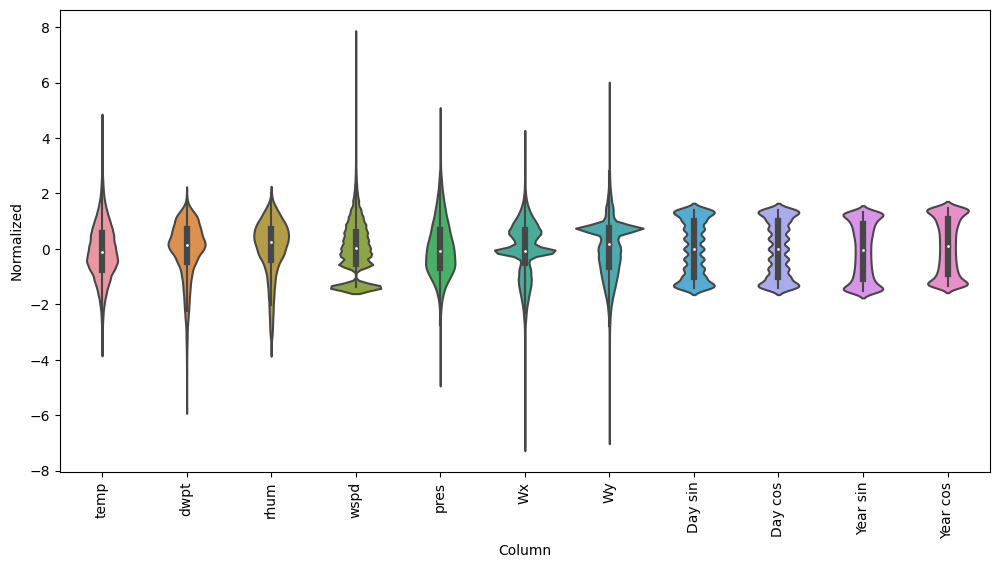

In [339]:
# Standardize the entire DataFrame using the mean and std from the training dataset
df_std = (df - train_mean) / train_std

# Melt the DataFrame to transform it to long format for visualization
df_std = df_std.melt(var_name='Column', value_name='Normalized')

# Set up the figure and axis for the violin plot
plt.figure(figsize=(12, 6))
ax = sns.violinplot(x='Column', y='Normalized', data=df_std)

# Rotate x-axis labels for better readability
_ = ax.set_xticklabels(df.keys(), rotation=90)


Some features do have long tails, but there are no obvious errors

#5.Data windowing

prediction 24 hours into the future, given 24 hours of history
timestep= 60mins= 1 hour
window size 60 mins=1 day

In [400]:
class WindowGenerator():
    def __init__(self, input_width, label_width, shift,
                 train_df=train_df, val_df=val_df, test_df=test_df,
                 label_columns=None):
        # Store the raw data.
        self.train_df = train_df
        self.val_df = val_df
        self.test_df = test_df

        # Work out the label column indices.
        self.label_columns = label_columns
        if label_columns is not None:
            # Create a dictionary to map label column names to indices
            self.label_columns_indices = {name: i for i, name in enumerate(label_columns)}

        # Create a dictionary to map all column names to indices
        self.column_indices = {name: i for i, name in enumerate(train_df.columns)}

        # Work out the window parameters.
        self.input_width = input_width
        self.label_width = label_width
        self.shift = shift

        # Calculate the total window size
        self.total_window_size = input_width + shift

        # Define slices and indices for input and label windows
        self.input_slice = slice(0, input_width)
        self.input_indices = np.arange(self.total_window_size)[self.input_slice]

        self.label_start = self.total_window_size - self.label_width
        self.labels_slice = slice(self.label_start, None)
        self.label_indices = np.arange(self.total_window_size)[self.labels_slice]

    def __repr__(self):
        # Return a string representation of the class
        return '\n'.join([
            f'Total window size: {self.total_window_size}',
            f'Input indices: {self.input_indices}',
            f'Label indices: {self.label_indices}',
            f'Label column name(s): {self.label_columns}'
        ])


***window object*** 24 time steps aead prediction with 24 time steps behind

In [401]:
OUT_STEPS = 24
multi_window = WindowGenerator(input_width=24,label_width=OUT_STEPS,shift=OUT_STEPS,label_columns=['wspd'])

##split

In [402]:
def split_window(self, features):
  inputs = features[:, self.input_slice, :]
  labels = features[:, self.labels_slice, :]
  if self.label_columns is not None:
    labels = tf.stack(
        [labels[:, :, self.column_indices[name]] for name in self.label_columns],
        axis=-1)

  # Slicing doesn't preserve static shape information, so set the shapes
  # manually. This way the `tf.data.Datasets` are easier to inspect.
  inputs.set_shape([None, self.input_width, None])
  labels.set_shape([None, self.label_width, None])

  return inputs, labels

WindowGenerator.split_window = split_window

##  Create `tf.data.Dataset`s

Finally, this `make_dataset` method will take a time series DataFrame and convert it to a `tf.data.Dataset` of `(input_window, label_window)` pairs using the `tf.keras.utils.timeseries_dataset_from_array` function:

In [403]:
def make_dataset(self, data):
  data = np.array(data, dtype=np.float32)
  ds = tf.keras.utils.timeseries_dataset_from_array(
      data=data,
      targets=None,
      sequence_length=self.total_window_size,
      sequence_stride=1,
      shuffle=True,
      batch_size=32,)

  ds = ds.map(self.split_window)

  return ds

WindowGenerator.make_dataset = make_dataset

The `WindowGenerator` object holds training, validation, and test data.


In [404]:
@property
def train(self):
  return self.make_dataset(self.train_df)

@property
def val(self):
  return self.make_dataset(self.val_df)

@property
def test(self):
  return self.make_dataset(self.test_df)

@property
def example(self):
  """Get and cache an example batch of `inputs, labels` for plotting."""
  result = getattr(self, '_example', None)
  if result is None:
    # No example batch was found, so get one from the `.train` dataset
    result = next(iter(self.train))
    # And cache it for next time
    self._example = result
  return result

WindowGenerator.train = train
WindowGenerator.val = val
WindowGenerator.test = test
WindowGenerator.example = example

Now, the `WindowGenerator` object gives you access to the `tf.data.Dataset` objects, so you can easily iterate over the data.

The `Dataset.element_spec` property tells you the structure, data types, and shapes of the dataset elements.

Iterating over a `Dataset` yields concrete batches:

## plots


In [405]:
def plot(self, model=None, plot_col='wspd', max_subplots=3):
  inputs, labels = self.example
  plt.figure(figsize=(12, 8))
  plot_col_index = self.column_indices[plot_col]
  max_n = min(max_subplots, len(inputs))
  for n in range(max_n):
    plt.subplot(max_n, 1, n+1)
    plt.ylabel(f'{plot_col} [normed]')
    plt.plot(self.input_indices, inputs[n, :, plot_col_index],
             label='Inputs', marker='.', zorder=-10)

    if self.label_columns:
      label_col_index = self.label_columns_indices.get(plot_col, None)
    else:
      label_col_index = plot_col_index

    if label_col_index is None:
      continue

    plt.scatter(self.label_indices, labels[n, :, label_col_index],
                edgecolors='k', label='Labels', c='#2ca02c', s=64)
    if model is not None:
      predictions = model(inputs)
      plt.scatter(self.label_indices, predictions[n, :, label_col_index],
                  marker='X', edgecolors='k', label='Predictions',
                  c='#ff7f0e', s=64)

    if n == 0:
      plt.legend()

  plt.xlabel('Time [h]')

WindowGenerator.plot = plot

# Baseline

Since this task is to predict 24 hours into the future, given 24 hours of the past,simple approach is to repeat the previous day, assuming tomorrow will be similar:


In [406]:
class RepeatBaseline(tf.keras.Model):
  def call(self, inputs):
    return inputs

In [407]:
multi_val_performance = {} # assign empty array to store performance on validation dataset
multi_performance = {}  # assign empty array to store performance on test dataset

279/279 [==============================] - 1s 4ms/step - loss: 1.9213 - mean_absolute_error: 1.0881


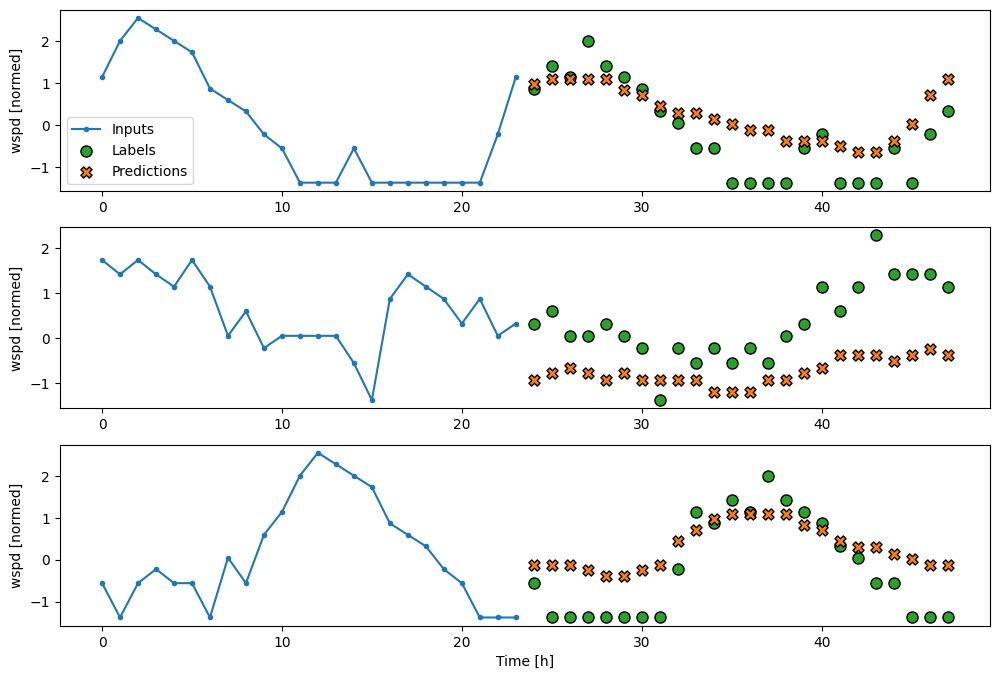

In [408]:
repeat_baseline = RepeatBaseline()# Create an instance of RepeatBaseline

# Compile the RepeatBaseline model
repeat_baseline.compile(loss=tf.keras.losses.MeanSquaredError(),
                        metrics=[tf.keras.metrics.MeanAbsoluteError()])

multi_val_performance['RepeatBaseline'] = repeat_baseline.evaluate(multi_window.val) #validation data performance
multi_performance['RepeatBaseline'] = repeat_baseline.evaluate(multi_window.test, verbose=0) #test data performanve
multi_window.plot(repeat_baseline)

##**packaged training procedure function**

In [409]:
# Import TensorFlow library
import tensorflow as tf

# Maximum number of training epochs
MAX_EPOCHS = 50

# Function to compile and fit a neural network model
def compile_and_fit(model, window, patience=5):
    # Define early stopping callback
    early_stopping = tf.keras.callbacks.EarlyStopping(
        monitor='val_loss',     # Monitor validation loss
        patience=patience,       # Number of epochs with no improvement after which training will be stopped
        mode='min'               # Stop when the monitored metric ('val_loss') stops decreasing (minimizing)
    )

    # Compile the model
    model.compile(
        loss=tf.keras.losses.MeanSquaredError(),           # Use Mean Squared Error loss function
        optimizer=tf.keras.optimizers.Adam(),              # Use the Adam optimizer
        metrics=[tf.keras.metrics.MeanAbsoluteError()]    # Monitor Mean Absolute Error metric
    )

    # Train the model
    history = model.fit(
        window.train,            # Training data
        epochs=MAX_EPOCHS,        # Maximum number of training epochs
        validation_data=window.val,  # Validation data
        callbacks=[early_stopping]   # List of callbacks, including early stopping
    )

    # Return the training history
    return history

# CNN

**Single-shot models**
One high-level approach to this problem is to use a "single-shot" model, where the model makes the entire sequence prediction in a single step


convolutional model with predict multiple steps(42time steps) using past 24 time steps

predict all features

Conv1D

In [410]:
# Set the convolution width
CONV_WIDTH = 8

# Create a Sequential model for the convolutional model
cnn_model = tf.keras.Sequential([
    # Shape [batch, time, features] => [batch, CONV_WIDTH, features]
    tf.keras.layers.Lambda(lambda x: x[:, -CONV_WIDTH:, :]),
    # Shape => [batch, 1, conv_units]
    tf.keras.layers.Conv1D(256, activation='relu', kernel_size=(CONV_WIDTH)),
    # Shape => [batch, 1, out_steps*features]
    tf.keras.layers.Dense(OUT_STEPS,
                          kernel_initializer=tf.initializers.zeros()),
    # Shape => [batch, out_steps, features]
    #tf.keras.layers.Dense(128, activation='relu'),  # Add another dense layer with 128 units and ReLU activation
    tf.keras.layers.Reshape([OUT_STEPS, 1])
    #tf.keras.layers.Dense(units=32, activation='relu'),
    #f.keras.layers.Dense(units=1),
])


history = compile_and_fit(cnn_model, multi_window)# Train the convolutional model using compile_and_fit function
IPython.display.clear_output()# Clear the IPython display



279/279 [==============================] - 1s 4ms/step - loss: 0.5076 - mean_absolute_error: 0.5252


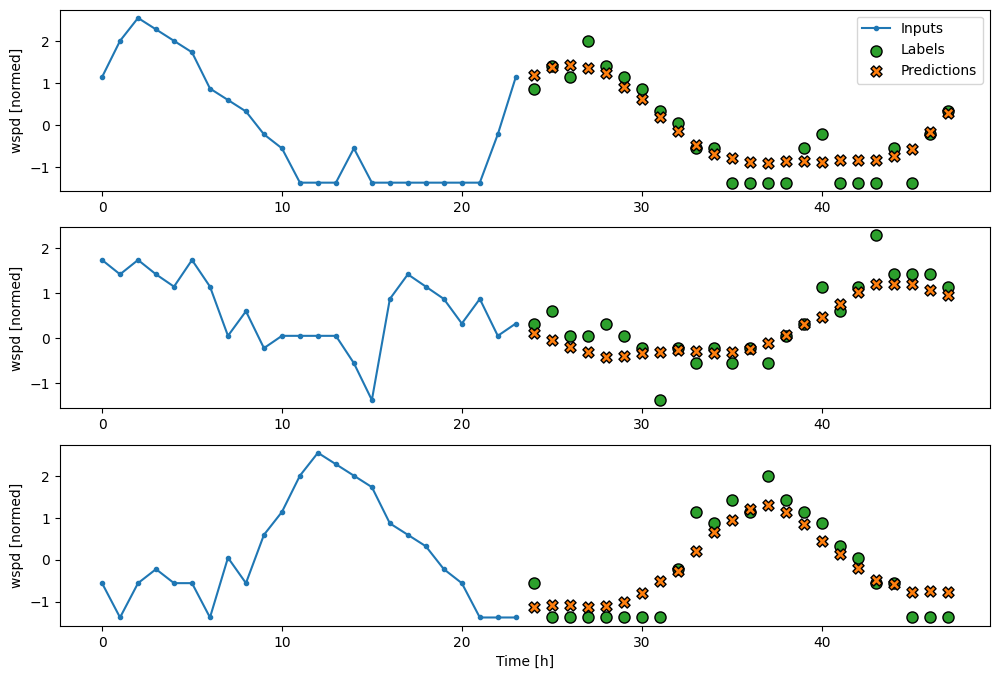

In [411]:
# Evaluate
multi_val_performance['1D_Conv'] = cnn_model.evaluate(multi_window.val)
multi_performance['1D_Conv'] = cnn_model.evaluate(multi_window.test, verbose=0)

# Plot the performance
multi_window.plot(cnn_model)

lstm cnn

In [412]:
# Set the convolution width
CONV_WIDTH = 8

# Create a Sequential model for the convolutional model
cnn_lstm_model = tf.keras.Sequential([
    # Shape [batch, time, features] => [batch, CONV_WIDTH, features]
    tf.keras.layers.Lambda(lambda x: x[:, -CONV_WIDTH:, :]),
    # Shape => [batch, 1, conv_units]
    #tf.keras.layers.Conv1D(256, activation='relu', kernel_size=(CONV_WIDTH)),
    tf.keras.layers.LSTM(256, activation='relu'),
    # Shape => [batch, 1, out_steps*features]
    tf.keras.layers.Dense(OUT_STEPS,
                          kernel_initializer=tf.initializers.zeros()),
    # Shape => [batch, out_steps, features]
    #tf.keras.layers.Dense(128, activation='relu'),  # Add another dense layer with 128 units and ReLU activation
    tf.keras.layers.Reshape([OUT_STEPS, 1])
])


history = compile_and_fit(cnn_lstm_model, multi_window)# Train the convolutional model using compile_and_fit function
IPython.display.clear_output()# Clear the IPython display




279/279 [==============================] - 2s 7ms/step - loss: 0.5578 - mean_absolute_error: 0.5477


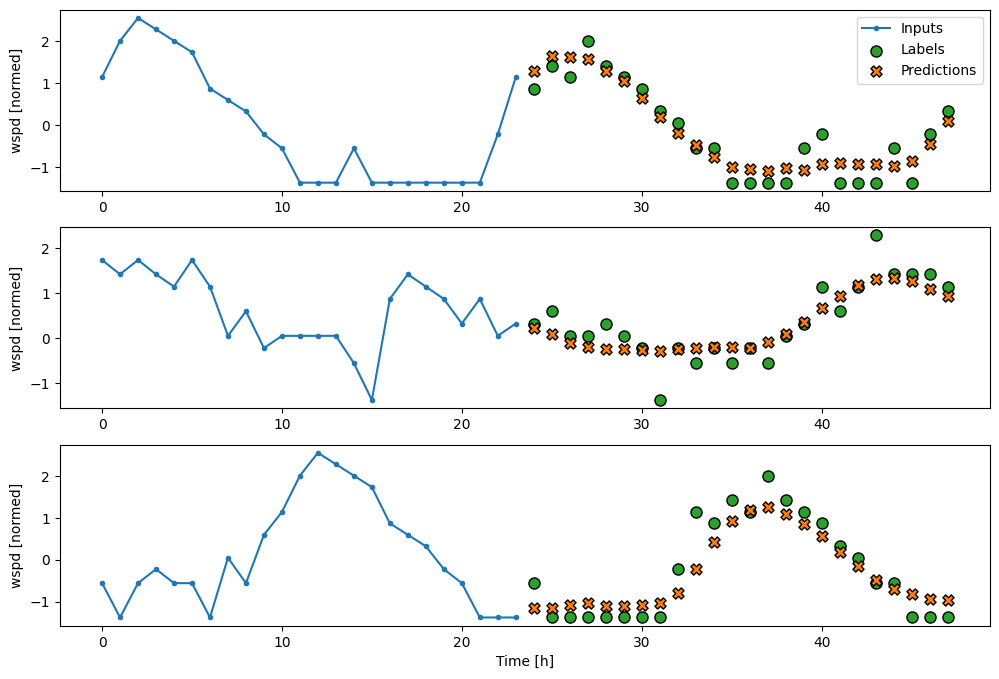

In [413]:
# Evaluate
multi_val_performance['lstm_Conv'] = cnn_lstm_model.evaluate(multi_window.val)
multi_performance['lstm_Conv'] = cnn_lstm_model.evaluate(multi_window.test, verbose=0)

# Plot the performance
multi_window.plot(cnn_lstm_model)

#RNN

In [414]:
Rnn_lstm_model = tf.keras.Sequential([
    # Shape [batch, time, features] => [batch, lstm_units].
    # Adding more `lstm_units` just overfits more quickly.
    tf.keras.layers.LSTM(256, return_sequences=False),
    # Shape => [batch, out_steps*features].
    tf.keras.layers.Dense(OUT_STEPS*num_features,
                          kernel_initializer=tf.initializers.zeros()),
    # Shape => [batch, out_steps, features].
    tf.keras.layers.Reshape([OUT_STEPS, num_features])
])

history = compile_and_fit(Rnn_lstm_model, multi_window)

IPython.display.clear_output()

multi_val_performance['LSTM'] = Rnn_lstm_model.evaluate(multi_window.val)
multi_performance['LSTM'] = Rnn_lstm_model.evaluate(multi_window.test, verbose=0)


279/279 [==============================] - 4s 15ms/step - loss: 0.5932 - mean_absolute_error: 0.5679


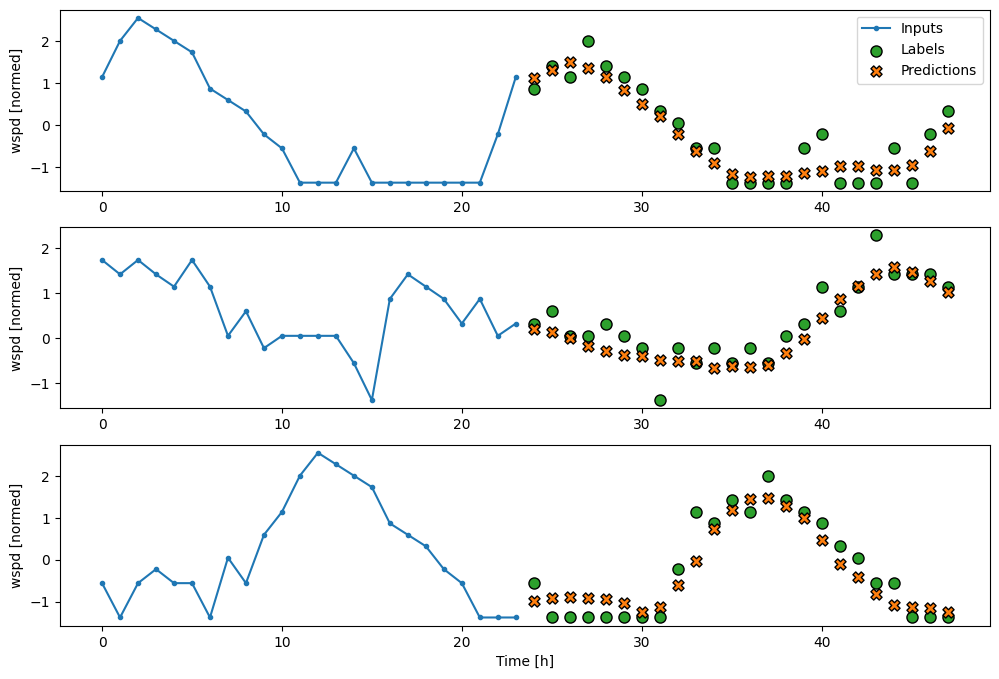

In [415]:
multi_window.plot(Rnn_lstm_model)

# Performance

There are clearly diminishing returns as a function of model complexity on this problem:

In [416]:
train_df.mean()

temp       -1.087982e-16
dwpt       -1.885835e-16
rhum       -4.351927e-17
wspd        7.615872e-17
pres        1.320085e-14
Wx          1.994633e-17
Wy          2.991950e-17
Day sin     2.643456e-17
Day cos     2.544291e-17
Year sin    7.253212e-17
Year cos    3.626606e-17
dtype: float64

In [417]:
x = np.arange(len(multi_performance))
multi_performance

{'RepeatBaseline': [2.100255250930786, 1.1611427068710327],
 '1D_Conv': [0.46458700299263, 0.534801185131073],
 'lstm_Conv': [0.5841335654258728, 0.5789903998374939],
 'LSTM': [0.6044986248016357, 0.594315230846405]}

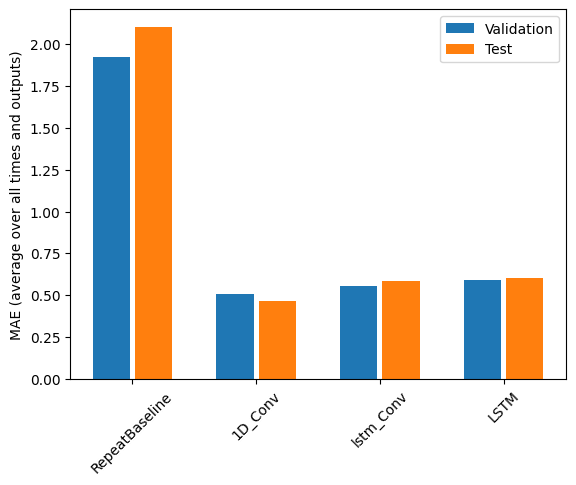

In [418]:
import numpy as np
import matplotlib.pyplot as plt

x = np.arange(len(multi_performance))
width = 0.3

val_mae = [v[0] for v in multi_val_performance.values()]
test_mae = [v[0] for v in multi_performance.values()]

plt.bar(x - 0.17, val_mae, width, label='Validation')
plt.bar(x + 0.17, test_mae, width, label='Test')
plt.xticks(ticks=x, labels=multi_performance.keys(), rotation=45)
plt.ylabel(f'MAE (average over all times and outputs)')
_ = plt.legend()
plt.show()


The metrics for the multi-output models in the first half of this tutorial show the performance averaged across all output features. These performances are similar but also averaged across output time steps.